In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("..", "src")))
from pathlib import Path

samples_folder = Path("../../samples")

In [2]:
# This notebook inspect the samples I generated for the 1000 events with 50 pileup IVF

In [3]:
import uproot
import mplhep as hep
import awkward as ak
import hist
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [26]:
file_path = (
    samples_folder / "sample/n1000_npu50_IVF/vertex_n1000_npu50_IVF.root"
)

vertex_algo = "IVF"

In [5]:
file = uproot.open(file_path)

In [6]:
file.keys()

['ML_tracks;2', 'ML_tracks;1', 'vertexing;1']

In [7]:
file["ML_tracks"].keys()

['event_nr',
 'reco_PriVtxX',
 'reco_PriVtxY',
 'reco_PriVtxZ',
 'truth_PriVtxX',
 'truth_PriVtxY',
 'truth_PriVtxZ',
 'reco_trk_fit_d0',
 'reco_trk_fit_z0',
 'reco_trk_fit_phi',
 'reco_trk_fit_theta',
 'reco_trk_fit_qop',
 'reco_trk_fit_time',
 'reco_trk_fit_err_d0',
 'reco_trk_fit_err_z0',
 'reco_trk_fit_err_phi',
 'reco_trk_fit_err_theta',
 'reco_trk_fit_err_qop',
 'reco_trk_fit_err_time',
 'reco_trk_truth_vtx_idx',
 'reco_trk_reco_vtx_idx']

In [8]:
ML_tracks = file["ML_tracks"].arrays()

In [9]:
vertexing = file["vertexing"].arrays()

In [10]:
vertexing.fields

['diffx',
 'diffy',
 'diffz',
 'recoX',
 'recoY',
 'recoZ',
 'truthX',
 'truthY',
 'truthZ',
 'covXX',
 'covYY',
 'covXY',
 'covYX',
 'trkVtxMatch',
 'nRecoVtx',
 'nTrueVtx',
 'nVtxDetectorAcceptance',
 'nVtxReconstructable',
 'timeMS']

In [11]:
ak.count(ML_tracks.event_nr)

1000

In [12]:
ak.count(ML_tracks.truth_PriVtxZ)

51097

In [13]:
np.all(ak.count(ML_tracks.truth_PriVtxZ, axis=1) == 50)

False

In [14]:
np.mean(ak.count(ML_tracks.truth_PriVtxZ, axis=1))

51.097

In [15]:
output_path = Path("./n1000_npu50_IVF")
output_path.mkdir(
    parents=True, exist_ok=True
) if not output_path.exists() else None

# Truth Vertex distribution

## n truth vertex

In [16]:
hist_n_truth_PriVtx = hist.Hist(
    hist.axis.Regular(
        40,
        30,
        70,
        name="hist_n_truth_PriVtx",
        label="Number of Truth Primary Vertex",
    )
)
hist_n_truth_PriVtx.fill(ak.count(ML_tracks.truth_PriVtxZ, axis=1))

Hist(Regular(40, 30, 70, name='hist_n_truth_PriVtx', label='Number of Truth Primary Vertex'), storage=Double()) # Sum: 993.0 (1000.0 with flow)

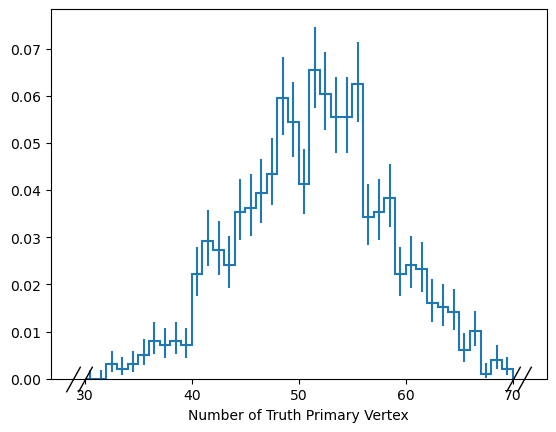

In [17]:
fig, ax = plt.subplots()
hep.histplot(hist_n_truth_PriVtx, density=True, histtype="step")
fig.savefig(output_path / "hist_n_truth_PriVtx.png")

## truth vertex vz

In [18]:
hist_truth_PriVtxZ = hist.Hist(
    hist.axis.Regular(
        101,
        -200,
        200,
        name="hist_truth_PriVtxZ",
        label="Truth Primary Vertex Z [mm]",
    )
)
hist_truth_PriVtxZ.fill(ak.flatten(ML_tracks["truth_PriVtxZ"]))

Hist(Regular(101, -200, 200, name='hist_truth_PriVtxZ', label='Truth Primary Vertex Z [mm]'), storage=Double()) # Sum: 51079.0 (51097.0 with flow)

55.88730469023926


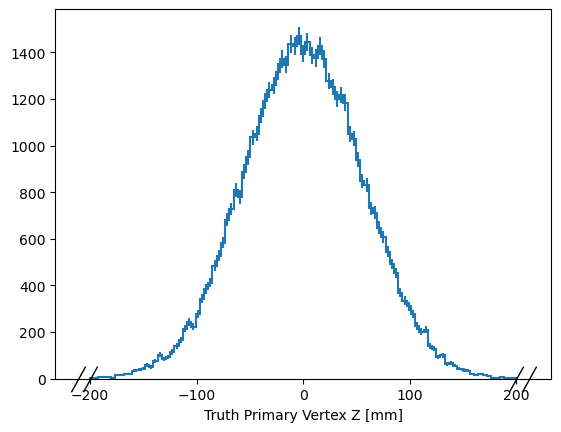

In [19]:
fig, axs = plt.subplots()
hep.histplot(hist_truth_PriVtxZ, density=False, histtype="step")
print(np.std(ak.flatten(ML_tracks["truth_PriVtxZ"])))
fig.savefig(output_path / "hist_truth_PriVtxZ.png")

# Reco Vertex distribution

## n reco vertex

In [20]:
hist_n_reco_PriVtx = hist.Hist(
    hist.axis.Regular(
        40,
        0,
        40,
        name="hist_n_reco_PriVtx",
        label="Number of Reco Primary Vertex",
    )
)
hist_n_reco_PriVtx.fill(ak.count(ML_tracks.reco_PriVtxZ, axis=1))

Hist(Regular(40, 0, 40, name='hist_n_reco_PriVtx', label='Number of Reco Primary Vertex'), storage=Double()) # Sum: 1000.0

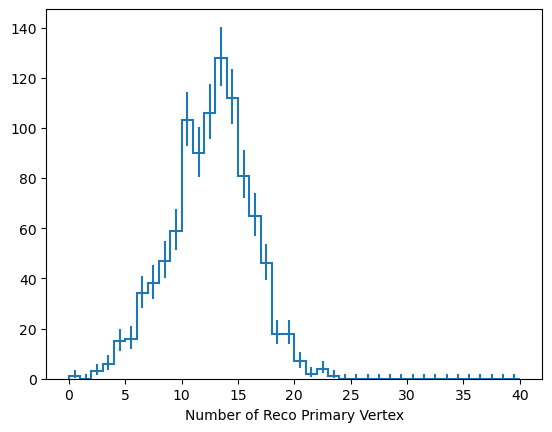

In [22]:
fig, ax = plt.subplots()
hep.histplot(hist_n_reco_PriVtx, density=False, histtype="step")
fig.savefig(output_path / "hist_n_reco_PriVtx.png")

## reco vertex vz

In [23]:
hist_reco_PriVtxZ = hist.Hist(
    hist.axis.Regular(
        101,
        -200,
        200,
        name="hist_reco_PriVtxZ",
        label="Reco Primary Vertex Z [mm]",
    )
)
hist_reco_PriVtxZ.fill(ak.flatten(ML_tracks["reco_PriVtxZ"]))

Hist(Regular(101, -200, 200, name='hist_reco_PriVtxZ', label='Reco Primary Vertex Z [mm]'), storage=Double()) # Sum: 12053.0 (12061.0 with flow)

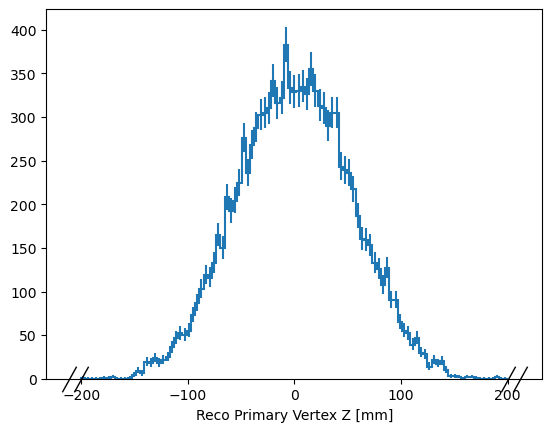

In [24]:
fig, ax = plt.subplots()
hep.histplot(hist_reco_PriVtxZ, density=False, histtype="step")
fig.savefig(output_path / "hist_reco_PriVtxZ.png")

# n reco vtx vs n truth vtx

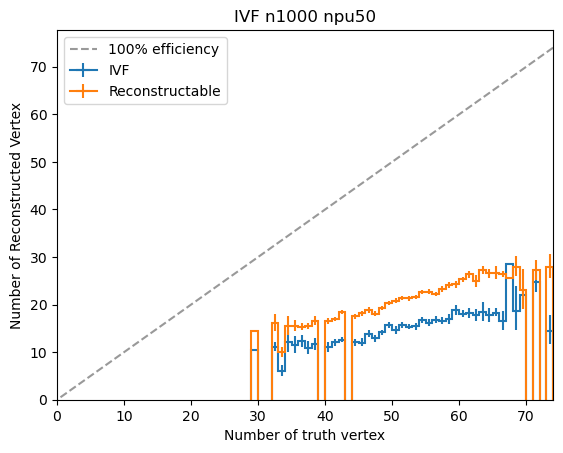

In [28]:
max_value = np.max(vertexing.nTrueVtx)

TH2_vtx_vs_pu = (
    hist.Hist.new.Reg(
        max_value,
        0,
        max_value,
        name="num_truth_vtx",
        label="Number of truth vertex",
        flow=True,
    )
    .Reg(
        max_value,
        0,
        max_value,
        name="num_reco_vtx",
        label="Number of reco vertex",
        flow=True,
    )
    .Double()
)
TH2_vtx_vs_pu.fill(vertexing.nTrueVtx, vertexing.nRecoVtx)
hprofile_truth_vs_reco = TH2_vtx_vs_pu.profile("num_reco_vtx")


TH2_reconstructable_vtx_vs_pu = (
    hist.Hist.new.Reg(
        max_value,
        0,
        max_value,
        name="num_truth_vtx",
        label="Number of truth vertex",
        flow=True,
    )
    .Reg(
        max_value,
        0,
        max_value,
        name="num_reconstructable_vtx_vs_pu",
        label="Number of reconstructable vertex",
        flow=True,
    )
    .Double()
)
TH2_reconstructable_vtx_vs_pu.fill(
    vertexing.nTrueVtx, vertexing.nVtxReconstructable
)
hprofile_reconstructable_vs_reco = TH2_reconstructable_vtx_vs_pu.profile(
    "num_reconstructable_vtx_vs_pu"
)

fig, ax = plt.subplots()
hprofile_truth_vs_reco.plot(label=vertex_algo)
hprofile_reconstructable_vs_reco.plot(label="Reconstructable")

# bin_values, bin_edges = hprofile.to_numpy()
# ax.stairs(bin_values,  bin_edges)
ax.set_ylabel("Number of Reconstructed Vertex")
ax.set_title(f"{vertex_algo} n1000 npu50")
ax.plot(
    [max_value, 0.0],
    [max_value, 0.0],
    "--",
    color=(0.6, 0.6, 0.6),
    label="100% efficiency",
)

ax.legend()
ax.set_xlim(0, max_value)
# ax.text(0.5, 0.5, f"Mean: {hprofile.values()[0]:.2f}", transform=ax.transAxes)
plt.savefig(output_path / "num_vtx_vs_pu.png")

# reco vtx diff Z

In [29]:
def calculate_differenceZ(vtx_vz: ak.highlevel.Array):
    differenceZ = []
    for vtx_vz_event in vtx_vz:
        distance_all_pairs = ak.flatten(vtx_vz_event[:, None] - vtx_vz_event)
        differenceZ.append(distance_all_pairs[distance_all_pairs != 0])

    return differenceZ

In [30]:
reco_vtx_vz = ML_tracks.reco_PriVtxZ
truth_vtx_vz = ML_tracks.truth_PriVtxZ


### Plot the reco vtx
hist_differenceZ = hist.Hist(
    hist.axis.Regular(bins=50, start=-5, stop=5, name="diffZ")
)
differenceZ = calculate_differenceZ(reco_vtx_vz)
# flatten the list
differenceZ = np.concatenate(differenceZ)
hist_differenceZ.fill(differenceZ)
# plot_hist(hist_differenceZ, output_path, output_name=f'diffZ_amvf_pu{pu_number}', pu_number = pu_number, is_truth=False)

### Plot the truth vtx
differenceZ_truth = calculate_differenceZ(truth_vtx_vz)
hist_differenceZ_truth = hist_differenceZ.copy()
hist_differenceZ_truth.reset()
differenceZ_truth = np.concatenate(differenceZ_truth)
hist_differenceZ_truth.fill(differenceZ_truth)
# plot_hist(hist_differenceZ_truth, output_path, output_name=f'diffZ_truth_pu{pu_number}', pu_number = pu_number, is_truth=True)

Hist(Regular(50, -5, 5, name='diffZ'), storage=Double()) # Sum: 131658.0 (2610474.0 with flow)

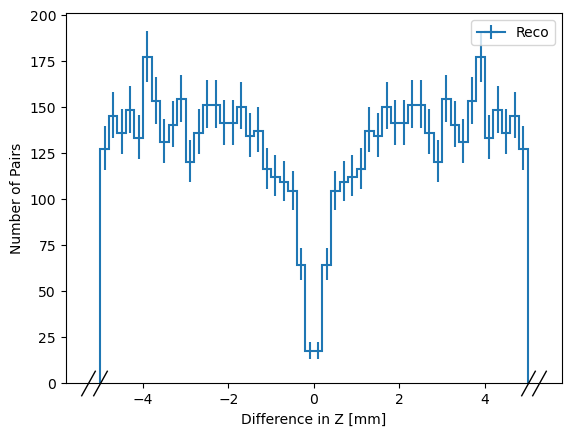

In [31]:
fig, ax = plt.subplots()

hep.histplot(hist_differenceZ, density=False, histtype="step", label="Reco")
# hep.histplot(hist_differenceZ_truth, density=False, histtype='step', label="Truth")
ax.set_xlabel("Difference in Z [mm]")
ax.set_ylabel("Number of Pairs")
ax.legend()
fig.savefig(output_path / "diffZ.png")

# Reco Vertex classification

In [ ]:
from enum import Enum

vxMatchWeight = 0.7
cutMinTruthRecoRadialDiff = 0.1


class VertexMatchType(Enum):
    """Copy the definitions here
    https://acode-browser1.usatlas.bnl.gov/lxr/source/athena/InnerDetector/InDetValidation/InDetTruthVertexValidation/InDetTruthVertexValidation/InDetVertexTruthMatchUtils.h?v=21.9#0020
    """

    MATCHED = 0
    MERGED = 1
    SPLIT = 2
    FAKE = 3
    DUMMY = 4
    NTYPES = 5


class HardScatterType(Enum):
    """Copy the definitions here
    https://acode-browser1.usatlas.bnl.gov/lxr/source/athena/InnerDetector/InDetValidation/InDetTruthVertexValidation/InDetTruthVertexValidation/InDetVertexTruthMatchUtils.h?v=21.9#0030
    """

    CLEAN = 0
    LOWPU = 1
    HIGHPU = 2
    HSSPLIT = 3
    NONE = 4
    NHSTYPES = 5


def classifyRecoVertex(RecoVertexMatchInfo: np.ndarray) -> list:
    reco_vtx_type = np.zeros(VertexMatchType.NTYPES.value, dtype=int)
    n_reco_vtx = RecoVertexMatchInfo.shape[0]
    vtx_types = np.zeros(n_reco_vtx, dtype=int)

    for reco_vtx_id in range(n_reco_vtx):
        max_weight_idx = np.argmax(RecoVertexMatchInfo[:, :, 1][reco_vtx_id])
        if (
            RecoVertexMatchInfo[:, :, 1][reco_vtx_id][max_weight_idx]
            > vxMatchWeight
            and RecoVertexMatchInfo[:, :, 2][reco_vtx_id][max_weight_idx]
            == Raw_RecoVertexMatchInfo[reco_vtx_id, :, 2].max()
        ):
            # labelled as matched/clean
            reco_vtx_type[VertexMatchType.MATCHED.value] += 1
            vtx_types[reco_vtx_id] = VertexMatchType.MATCHED.value
        elif (
            RecoVertexMatchInfo[:, :, 1][reco_vtx_id][max_weight_idx]
            < vxMatchWeight
            and RecoVertexMatchInfo[:, :, 2][reco_vtx_id][max_weight_idx]
            == Raw_RecoVertexMatchInfo[reco_vtx_id, :, 2].max()
        ):
            # labelled as merged
            reco_vtx_type[VertexMatchType.MERGED.value] += 1
            vtx_types[reco_vtx_id] = VertexMatchType.MERGED.value
        else:
            # labelled as spilt
            reco_vtx_type[VertexMatchType.SPLIT.value] += 1
            vtx_types[reco_vtx_id] = VertexMatchType.SPLIT.value

    return vtx_types, reco_vtx_type


def classifyHardScatter(
    RecoVertexMatchInfo: np.ndarray, vtx_types: dict
) -> HardScatterType:
    # count how many reco vtx the truth HS contributes to
    n_contribution_from_truth_HS = np.count_nonzero(
        RecoVertexMatchInfo[:, 0, 0]
    )

    if n_contribution_from_truth_HS == 0:
        return HardScatterType.NONE
    elif n_contribution_from_truth_HS == 1:
        # find the only one reco idx that truth HS contributes to
        reco_vtx_idx = np.flatnonzero(RecoVertexMatchInfo[:, 0, 0] != 0)[0]
        # check if the
        # FIXME athena uses the weights but here I use the sum of pt2
        is_largest_contribution = reco_vtx_idx == np.argmax(
            RecoVertexMatchInfo[reco_vtx_idx, :, 2]
        )
        reco_vtx_type = vtx_types[reco_vtx_idx]
        if (
            is_largest_contribution
            and reco_vtx_type == VertexMatchType.MATCHED
        ):
            return HardScatterType.CLEAN
        elif (
            is_largest_contribution and reco_vtx_type == VertexMatchType.MERGED
        ):
            return HardScatterType.LOWPU
        else:
            return HardScatterType.HIGHPU
    else:
        # multiple reco vertices have tracks from hard-scatter
        # count how many have hard-scatter tracks as largest contribution
        reco_vtxs_idx = np.flatnonzero(RecoVertexMatchInfo[:, 0, 0] != 0)
        largest_contributution_idxs = np.argmax(
            RecoVertexMatchInfo[reco_vtxs_idx, :, 2], axis=1
        )
        n_largest_contribution_from_truth_HS = np.count_nonzero(
            largest_contributution_idxs == 0
        )
        if n_largest_contribution_from_truth_HS == 0:
            return HardScatterType.HIGHPU
        elif n_largest_contribution_from_truth_HS == 1:
            # Only one reco vtx has the largest contribution
            # identify this reco vtx
            reco_vtx_idx = reco_vtxs_idx[
                np.where(largest_contributution_idxs == 0)[0][0]
            ]
            # take its vtx type
            reco_vtx_type = vtx_types[reco_vtx_idx]
            # choose the event type
            if reco_vtx_type == VertexMatchType.MATCHED:
                return HardScatterType.CLEAN
            elif reco_vtx_type == VertexMatchType.MERGED:
                return HardScatterType.LOWPU
            else:
                return HardScatterType.HIGHPU
        else:
            return HardScatterType.HSSPLIT

In [ ]:
def flatten_event(event: ak.highlevel.Record):
    """Event base flattening and return the performance

    Args:
        event (ak.highlevel.Record): _description_
    """
    reco_vtx_vz = event.reco_PriVtxZ
    truth_vtx_vz = event.truth_PriVtxZ

    n_reco_vtx = len(reco_vtx_vz)
    n_truth_vtx = len(truth_vtx_vz)

    Raw_RecoVertexMatchInfo = np.zeros(
        (n_reco_vtx + 1, n_truth_vtx + 1, 3), dtype=float
    )

    reco_trk_dict = {}
    for field in event.fields:
        if not field.startswith("reco_trk_"):
            continue

        if field == "reco_trk_reco_vtx_idx":
            continue
        reco_trk_dict[field] = event[field]

    reco_trk_df = pd.DataFrame(reco_trk_dict)

    # Calculate the pt2 of the reco track
    reco_trk_df["reco_trk_fit_pt2"] = (
        (1.0 / reco_trk_df["reco_trk_fit_qop"])
        * np.sin(reco_trk_df["reco_trk_fit_theta"])
    ) ** 2

    # Attach reco_trk_reco_vtx_idx to reco_trk_df
    # TODO: apply for the case of multiple reco vtx of a reco track
    reco_trk_df["reco_trk_reco_vtx_idx"] = event.reco_trk_reco_vtx_idx

    for trk_idx in range(len(reco_trk_df)):
        trk = reco_trk_df.iloc[trk_idx]
        truth_vtx_idx = int(trk["reco_trk_truth_vtx_idx"])
        reco_vtx_idx = int(trk["reco_trk_reco_vtx_idx"])
        if reco_vtx_idx == -999:
            continue
        elif reco_vtx_idx == -99:
            continue
        Raw_RecoVertexMatchInfo[reco_vtx_idx, truth_vtx_idx, 0] += 1
        Raw_RecoVertexMatchInfo[reco_vtx_idx, truth_vtx_idx, 1] += trk[
            "reco_trk_fit_pt2"
        ]

    assert np.sum(Raw_RecoVertexMatchInfo[:, :, 0]) == np.sum(
        reco_trk_df["reco_trk_reco_vtx_idx"] >= 0
    )

    RecoVertexMatchInfo = np.copy(Raw_RecoVertexMatchInfo)
    RecoVertexMatchInfo[:, :, 1] = Raw_RecoVertexMatchInfo[
        :, :, 1
    ] / Raw_RecoVertexMatchInfo[:, :, 1].sum(axis=0)
    RecoVertexMatchInfo[np.isnan(RecoVertexMatchInfo)[:, :, 1]] = 0

    return RecoVertexMatchInfo

In [ ]:
total_reco_vtx_type = np.zeros(VertexMatchType.NTYPES.value, dtype=int)
total_hs_type = np.zeros(HardScatterType.NHSTYPES.value, dtype=int)

for event_idx, event_nr in enumerate(ML_tracks.event_nr):
    if event_idx % 100 == 0:
        print(f"Processing event {event_idx} / {len(ML_tracks.event_nr)}")
    event = ML_tracks[event_idx]
    RecoVertexMatchInfo = flatten_event(event)
    vtx_types, vtx_types = classifyRecoVertex(RecoVertexMatchInfo)
    hs_type = classifyHardScatter(RecoVertexMatchInfo, vtx_types)

    total_reco_vtx_type = total_reco_vtx_type + vtx_types
    total_hs_type[hs_type.value] += 1

In [ ]:
flatten_event(ML_tracks[1])

In [ ]:
hs_type

In [ ]:
ML_tracks

In [ ]:
event = ML_tracks[1]
reco_vtx_vz = event.reco_PriVtxZ
truth_vtx_vz = event.truth_PriVtxZ
n_reco_vtx = len(reco_vtx_vz)
n_truth_vtx = len(truth_vtx_vz)

In [ ]:
n_truth_vtx

In [ ]:
reco_trk_dict = {}
for field in event.fields:
    if not field.startswith("reco_trk_"):
        continue

    if field == "reco_trk_reco_vtx_idx":
        continue
    reco_trk_dict[field] = event[field]

In [ ]:
reco_trk_df = pd.DataFrame(reco_trk_dict)

In [ ]:
# Calculate the pt2 of the reco track
reco_trk_df["reco_trk_fit_pt2"] = (
    (1.0 / reco_trk_df["reco_trk_fit_qop"])
    * np.sin(reco_trk_df["reco_trk_fit_theta"])
) ** 2

# Attach reco_trk_reco_vtx_idx to reco_trk_df
reco_trk_df["reco_trk_reco_vtx_idx"] = event.reco_trk_reco_vtx_idx

# TODO: apply for the case of multiple reco vtx of a reco track

In [ ]:
reco_trk_df

In [ ]:
Raw_RecoVertexMatchInfo = np.zeros((n_reco_vtx, n_truth_vtx, 3), dtype=float)

for trk_idx in range(len(reco_trk_df)):
    trk = reco_trk_df.iloc[trk_idx]
    truth_vtx_idx = int(trk["reco_trk_truth_vtx_idx"])
    reco_vtx_idx = int(trk["reco_trk_reco_vtx_idx"])
    if reco_vtx_idx == -999:
        continue
    elif reco_vtx_idx == -99:
        continue
    Raw_RecoVertexMatchInfo[reco_vtx_idx, truth_vtx_idx, 0] += 1